CNN Delta Predictor Key Features:
1. 1D CNN with residual connections for feature extraction
2. Separate branches for calls and puts with different processing
3. Option type embedding for context-aware predictions
4. Attention mechanism for feature importance weighting
5. Historical options data integration from Alpha Vantage API
6. Explicit handling of 50 calls and 50 puts
7. Advanced feature engineering including:
   - Log moneyness and time features
   - Market microstructure indicators
   - Interaction terms
8. Comprehensive evaluation and visualization
9. Synthetic data generation when API data unavailable
10. GPU acceleration when available

Starting CNN Options Delta Prediction
PyTorch Device: cpu
Starting CNN Delta Analysis for AAPL
Retrieving historical options data for AAPL...
Retrieved 2388 historical options records
Parsed 2388 historical options records
Current stock price: $240.00
Preparing training data with 50 calls and 50 puts...
Final training data: 96 samples
Calls: 

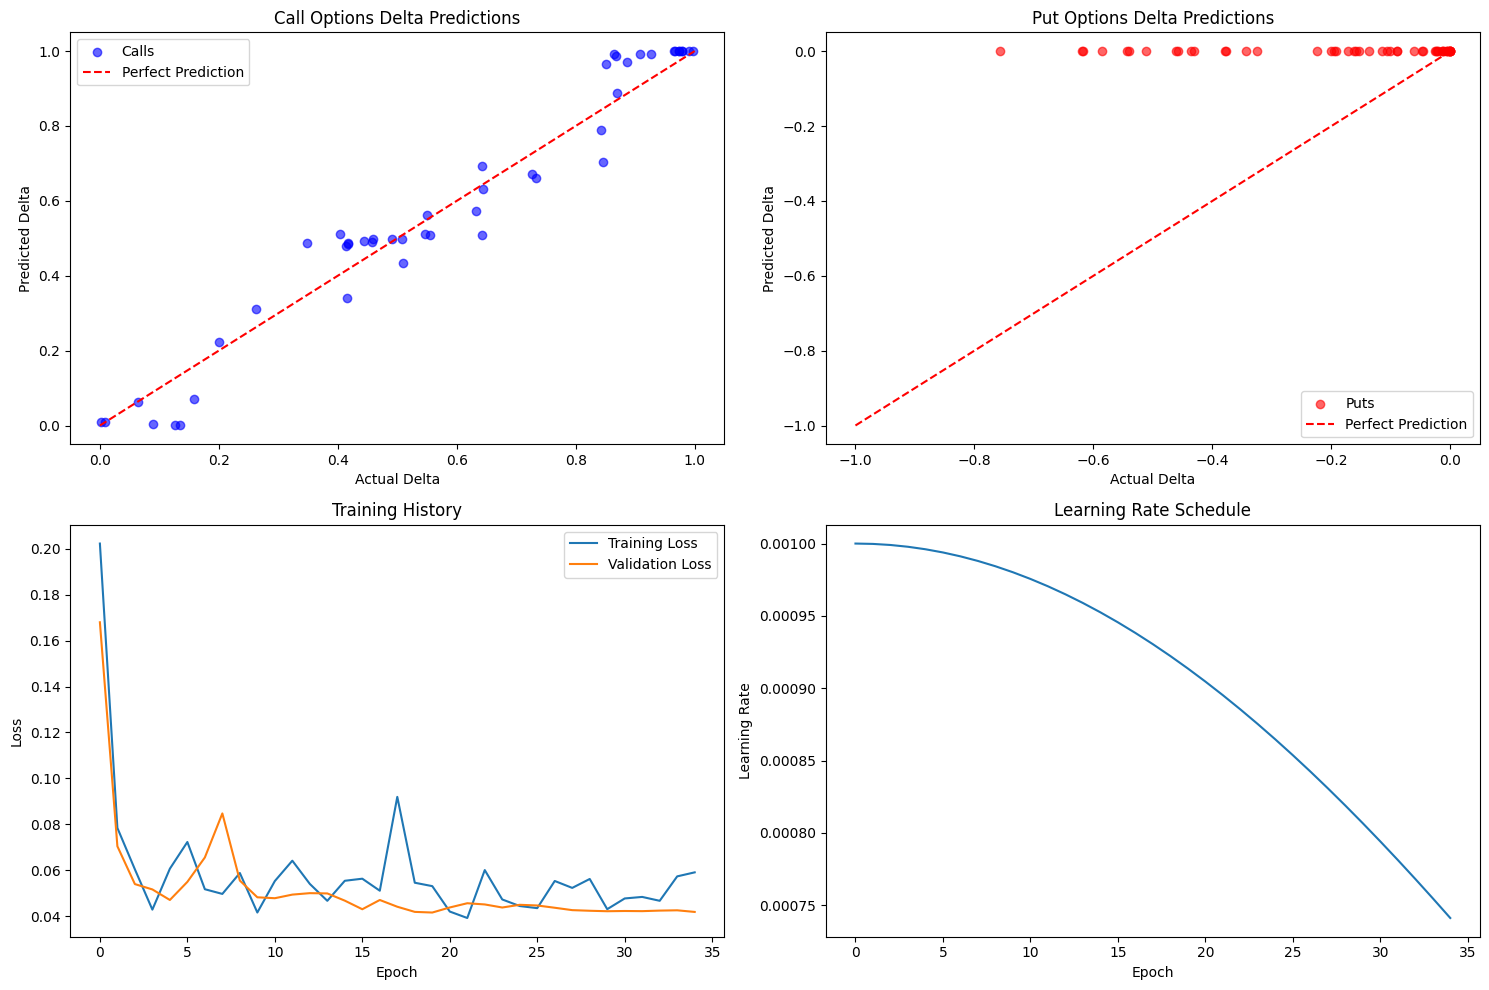

Results plot saved to 'cnn_delta_predictions.png'
Detailed results saved to AAPL_cnn_delta_analysis_20250828_151922.csv

Summary Statistics:
Total samples: 96
Calls: 47
Puts: 49
Current stock price: $240.00
Call delta range: 0.001 to 1.000
Call delta mean: 0.596
Put delta range: 0.001 to -0.000
Put delta mean: 0.000

Analysis Complete!
Check the generated files:
- cnn_delta_predictions.png (visualization)
- AAPL_cnn_delta_analysis_[timestamp].csv (detailed results)
- best_cnn_delta_model.pth (trained model)
Extended CNN Delta Analysis with Surface Visualization
PyTorch Device: cpu
Starting CNN Delta Analysis for AAPL
Retrieving historical options data for AAPL...
Retrieved 2388 historical options records
Parsed 2388 historical options records
Current stock price: $240.00
Preparing training data with 50 calls and 50 puts...
Final training data: 96 samples
Calls: 47, Puts: 49
Delta range: 0.0006 - 0.9971
Training CNN model (100 epochs, batch_size=32)...
Epoch 1/100 - Loss: 0.206196, Val 

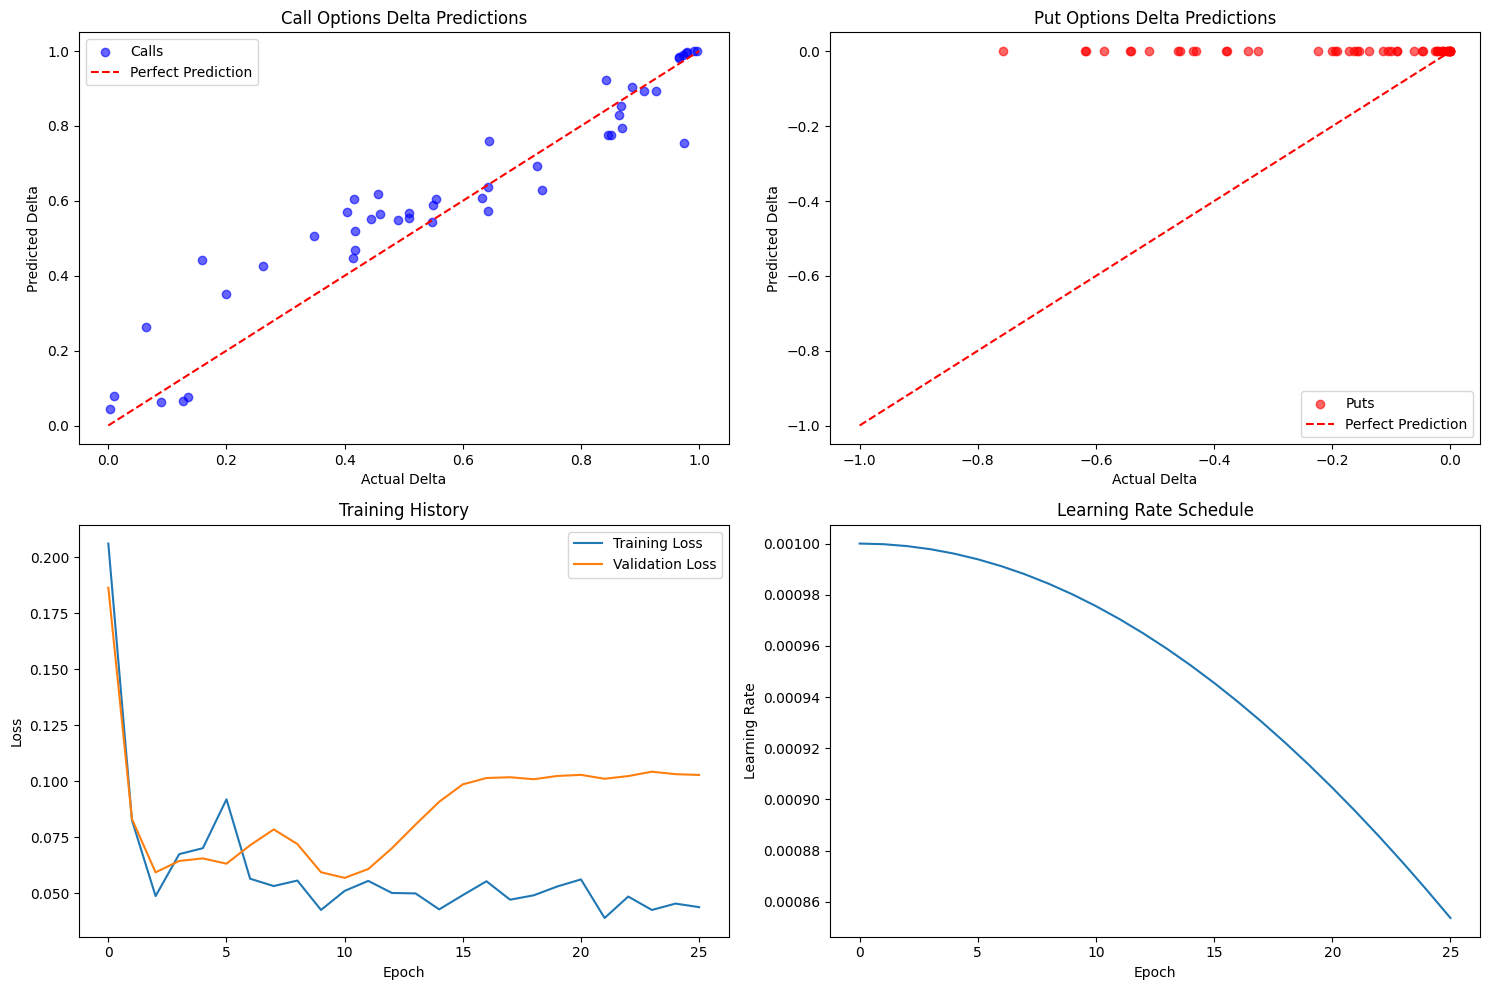

Results plot saved to 'cnn_delta_predictions.png'
Detailed results saved to AAPL_cnn_delta_analysis_20250828_151928.csv

Summary Statistics:
Total samples: 96
Calls: 47
Puts: 49
Current stock price: $240.00
Call delta range: 0.045 to 1.000
Call delta mean: 0.624
Put delta range: 0.001 to -0.000
Put delta mean: 0.000

Generating delta surfaces...


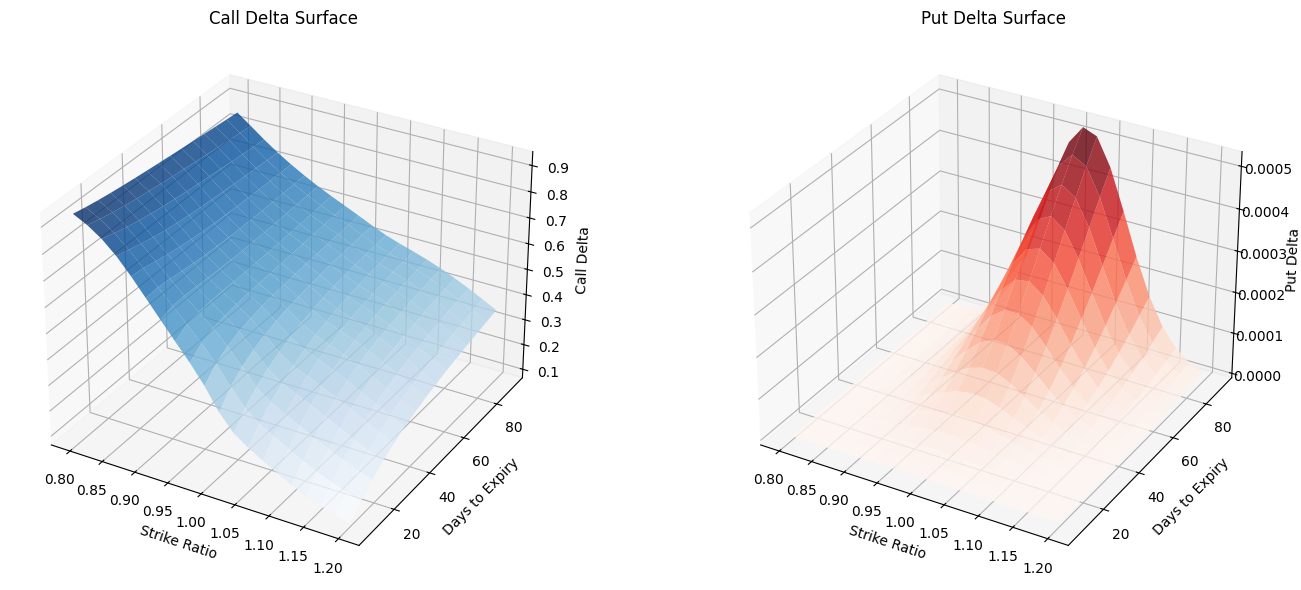

Delta surfaces saved to 'delta_surfaces.png'

Performing sensitivity analysis...
Call Delta Sensitivities:
  log_moneyness_neg_sensitivity: nan
  log_moneyness_pos_sensitivity: nan
  sqrt_time_neg_sensitivity: 0.108826
  sqrt_time_pos_sensitivity: 0.108586
  log_time_neg_sensitivity: -0.000347
  log_time_pos_sensitivity: 0.000614
  implied_volatility_neg_sensitivity: -1.452534
  implied_volatility_pos_sensitivity: -1.586559
  log_volume_neg_sensitivity: -0.021153
  log_volume_pos_sensitivity: -0.016205
  log_open_interest_neg_sensitivity: -0.011399
  log_open_interest_pos_sensitivity: -0.006061
  moneyness_time_neg_sensitivity: nan
  moneyness_time_pos_sensitivity: nan
  iv_time_neg_sensitivity: 0.174363
  iv_time_pos_sensitivity: 0.154996

Put Delta Sensitivities:
  log_moneyness_neg_sensitivity: nan
  log_moneyness_pos_sensitivity: nan
  sqrt_time_neg_sensitivity: -0.000184
  sqrt_time_pos_sensitivity: -0.000199
  log_time_neg_sensitivity: -0.000024
  log_time_pos_sensitivity: -0.000

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import requests
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# Load environment variables
load_dotenv()
ALPHA_VANTAGE_API_KEY = os.getenv('ALPHA_VANTAGE_API_KEY')

class OptionsDataset(Dataset):
    """Dataset for options with data augmentation"""
    def __init__(self, features, targets, option_types, augment=False):
        self.features = torch.from_numpy(features.astype(np.float32))
        self.targets = torch.from_numpy(targets.astype(np.float32))
        self.option_types = torch.from_numpy(option_types.astype(np.float32))  # 1 for calls, 0 for puts
        self.augment = augment
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        features = self.features[idx]
        targets = self.targets[idx]
        option_type = self.option_types[idx]
        
        if self.augment and torch.rand(1) > 0.5:
            # Add small gaussian noise for regularization
            noise = torch.normal(0, 0.005, features.shape)
            features = features + noise
            
        return features, targets, option_type

class CNN1DBlock(nn.Module):
    """1D CNN block with batch norm and residual connections"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(CNN1DBlock, self).__init__()
        
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm1d(out_channels)
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(0.1)
        
        # Skip connection
        self.skip_connection = None
        if in_channels != out_channels or stride != 1:
            self.skip_connection = nn.Conv1d(in_channels, out_channels, 1, stride)
    
    def forward(self, x):
        residual = x
        
        out = self.conv(x)
        out = self.bn(out)
        out = self.activation(out)
        out = self.dropout(out)
        
        # Apply skip connection
        if self.skip_connection:
            residual = self.skip_connection(residual)
        
        return out + residual

class CNNDeltaPredictor(nn.Module):
    """CNN-based delta predictor with separate branches for puts and calls"""
    def __init__(self, input_features=8, hidden_channels=64, num_blocks=4):
        super(CNNDeltaPredictor, self).__init__()
        
        self.input_features = input_features
        
        # Input projection to create multiple channels
        self.input_projection = nn.Linear(input_features, hidden_channels)
        
        # CNN feature extractor
        self.cnn_blocks = nn.ModuleList()
        channels = [hidden_channels, hidden_channels*2, hidden_channels*3, hidden_channels*4]
        
        for i in range(num_blocks):
            in_ch = channels[i] if i < len(channels) else channels[-1]
            out_ch = channels[i+1] if i+1 < len(channels) else channels[-1]
            self.cnn_blocks.append(CNN1DBlock(in_ch, out_ch))
        
        # Adaptive pooling
        self.adaptive_pool = nn.AdaptiveAvgPool1d(8)
        
        # Option type embedding
        self.option_type_embedding = nn.Embedding(2, 32)  # 0 for puts, 1 for calls
        
        # Feature fusion
        fusion_input_size = channels[-1] * 8 + 32  # CNN features + option type embedding
        
        # Separate branches for puts and calls
        self.call_branch = nn.Sequential(
            nn.Linear(fusion_input_size, hidden_channels*2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_channels*2, hidden_channels),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels, 32),
            nn.GELU(),
            nn.Linear(32, 1),
            nn.Sigmoid()  # Delta for calls: 0 to 1
        )
        
        self.put_branch = nn.Sequential(
            nn.Linear(fusion_input_size, hidden_channels*2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_channels*2, hidden_channels),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels, 32),
            nn.GELU(),
            nn.Linear(32, 1),
            nn.Sigmoid()  # Delta for puts: 0 to 1 (will be negated later)
        )
        
        # Attention mechanism for feature importance
        self.feature_attention = nn.Sequential(
            nn.Linear(fusion_input_size, fusion_input_size // 2),
            nn.GELU(),
            nn.Linear(fusion_input_size // 2, fusion_input_size),
            nn.Sigmoid()
        )
        
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv1d)):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
    
    def forward(self, x, option_types):
        batch_size = x.size(0)
        
        # Project to multiple channels and reshape for CNN
        x_proj = self.input_projection(x)  # (batch, hidden_channels)
        x_cnn = x_proj.unsqueeze(2).repeat(1, 1, self.input_features)  # (batch, hidden_channels, input_features)
        
        # Pass through CNN blocks
        for block in self.cnn_blocks:
            x_cnn = block(x_cnn)
        
        # Adaptive pooling and flatten
        x_cnn = self.adaptive_pool(x_cnn)  # (batch, channels[-1], 8)
        x_cnn_flat = x_cnn.view(batch_size, -1)  # (batch, channels[-1] * 8)
        
        # Option type embedding
        option_type_emb = self.option_type_embedding(option_types.long())  # (batch, 32)
        
        # Fuse CNN features with option type
        fused_features = torch.cat([x_cnn_flat, option_type_emb], dim=1)
        
        # Apply attention
        attention_weights = self.feature_attention(fused_features)
        attended_features = fused_features * attention_weights
        
        # Separate processing for calls and puts
        call_mask = (option_types == 1).float().unsqueeze(1)
        put_mask = (option_types == 0).float().unsqueeze(1)
        
        call_output = self.call_branch(attended_features)
        put_output = -self.put_branch(attended_features)  # Negate for put deltas
        
        # Combine outputs based on option type
        delta_pred = call_mask * call_output + put_mask * put_output
        
        return delta_pred

class CNNOptionsPredictor:
    def __init__(self, api_key=None):
        self.api_key = api_key
        self.base_url = "https://www.alphavantage.co/query"
        self.scaler = RobustScaler()
        self.model = None
        self.model_trained = False
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.current_stock_price = None
        self.training_history = {'loss': [], 'val_loss': [], 'lr': []}
        
        print(f"PyTorch Device: {self.device}")
        if torch.cuda.is_available():
            print(f"GPU: {torch.cuda.get_device_name()}")
    
    def get_historical_options_data(self, symbol='AAPL'):
        """Get historical options data from Alpha Vantage API"""
        print(f"Retrieving historical options data for {symbol}...")
        
        if not self.api_key:
            print("No API key provided, generating synthetic data for demonstration...")
            return self.generate_synthetic_data(symbol)
        
        try:
            # Try historical options endpoint
            params = {
                'function': 'HISTORICAL_OPTIONS',
                'symbol': symbol,
                'apikey': self.api_key
            }
            
            response = requests.get(self.base_url, params=params, timeout=15)
            response.raise_for_status()
            data = response.json()
            
            if 'data' in data and len(data['data']) > 0:
                print(f"Retrieved {len(data['data'])} historical options records")
                return self.parse_historical_options(data['data'])
            else:
                print("No historical options data available, using stock data for synthetic generation...")
                return self.get_stock_based_synthetic_data(symbol)
                
        except Exception as e:
            print(f"API request failed: {str(e)}")
            print("Generating synthetic data for demonstration...")
            return self.generate_synthetic_data(symbol)
    
    def parse_historical_options(self, raw_data):
        """Parse historical options data from Alpha Vantage"""
        options_list = []
        
        for item in raw_data:
            try:
                # Extract the most recent price as current stock price
                if 'underlying_price' in item:
                    self.current_stock_price = float(item['underlying_price'])
                
                options_list.append({
                    'symbol': item.get('symbol'),
                    'type': item.get('type', 'call').lower(),
                    'strike': float(item.get('strike', 0)),
                    'expiration': item.get('expiration'),
                    'bid': float(item.get('bid', 0)),
                    'ask': float(item.get('ask', 0)),
                    'last': float(item.get('last', 0)),
                    'volume': int(item.get('volume', 0)),
                    'open_interest': int(item.get('open_interest', 0)),
                    'implied_volatility': float(item.get('implied_volatility', 0.25)),
                    'delta': float(item.get('delta', 0)),
                    'gamma': float(item.get('gamma', 0)),
                    'theta': float(item.get('theta', 0)),
                    'vega': float(item.get('vega', 0)),
                })
            except (ValueError, TypeError, KeyError):
                continue
        
        if len(options_list) < 100:
            raise ValueError(f"Insufficient historical options data: only {len(options_list)} records")
        
        df = pd.DataFrame(options_list)
        print(f"Parsed {len(df)} historical options records")
        
        if self.current_stock_price is None:
            # Estimate from ATM options
            atm_options = df[df['delta'].between(0.45, 0.55)]
            if len(atm_options) > 0:
                self.current_stock_price = atm_options['strike'].median()
            else:
                self.current_stock_price = df['strike'].median()
        
        print(f"Current stock price: ${self.current_stock_price:.2f}")
        return df
    
    def get_stock_based_synthetic_data(self, symbol):
        """Generate synthetic options data based on current stock price"""
        try:
            # Get current stock price
            params = {
                'function': 'TIME_SERIES_DAILY',
                'symbol': symbol,
                'apikey': self.api_key,
                'outputsize': 'compact'
            }
            
            response = requests.get(self.base_url, params=params, timeout=15)
            response.raise_for_status()
            data = response.json()
            
            if 'Time Series (Daily)' in data:
                time_series = data['Time Series (Daily)']
                latest_date = max(time_series.keys())
                self.current_stock_price = float(time_series[latest_date]['4. close'])
                print(f"Retrieved current stock price: ${self.current_stock_price:.2f}")
            else:
                raise ValueError("No stock data available")
                
        except Exception as e:
            print(f"Stock data retrieval failed: {e}")
            self.current_stock_price = 150.0  # Default fallback
        
        return self.generate_synthetic_data(symbol)
    
    def generate_synthetic_data(self, symbol):
        """Generate synthetic options data with realistic patterns"""
        if self.current_stock_price is None:
            self.current_stock_price = 150.0  # Default price
        
        print(f"Generating synthetic options data for {symbol} at ${self.current_stock_price:.2f}")
        
        options_list = []
        
        # Generate strikes around current price
        strikes = np.arange(
            self.current_stock_price * 0.8, 
            self.current_stock_price * 1.2, 
            2.5
        )
        
        # Different expiration periods
        expiration_days = [7, 14, 21, 30, 45, 60, 90]
        
        for strike in strikes:
            for days in expiration_days:
                moneyness = strike / self.current_stock_price
                time_to_expiry = days / 365.0
                
                # Generate both calls and puts
                for option_type in ['call', 'put']:
                    # Realistic delta calculation using simplified Black-Scholes
                    if option_type == 'call':
                        if moneyness <= 0.95:
                            base_delta = 0.65 + 0.25 * (0.95 - moneyness)
                        elif moneyness <= 1.05:
                            base_delta = 0.5 + 0.15 * (1 - moneyness)
                        else:
                            base_delta = 0.35 - 0.25 * (moneyness - 1.05)
                    else:  # put
                        if moneyness <= 0.95:
                            base_delta = -0.35 - 0.25 * (0.95 - moneyness)
                        elif moneyness <= 1.05:
                            base_delta = -0.5 - 0.15 * (1 - moneyness)
                        else:
                            base_delta = -0.65 + 0.25 * (moneyness - 1.05)
                    
                    # Adjust for time decay
                    time_adjustment = np.sqrt(time_to_expiry) * 0.1
                    delta = base_delta + np.random.normal(0, 0.05) + time_adjustment
                    
                    # Clamp delta to realistic ranges
                    if option_type == 'call':
                        delta = max(0.01, min(0.99, delta))
                    else:
                        delta = max(-0.99, min(-0.01, delta))
                    
                    # Generate other Greeks and market data
                    iv = np.random.uniform(0.15, 0.45)
                    volume = np.random.randint(1, 1000)
                    open_interest = np.random.randint(10, 5000)
                    
                    # Price calculations
                    intrinsic = max(0, (self.current_stock_price - strike) if option_type == 'call' 
                                     else (strike - self.current_stock_price))
                    time_value = iv * np.sqrt(time_to_expiry) * self.current_stock_price * 0.4
                    theoretical_price = intrinsic + time_value
                    
                    bid = max(0.01, theoretical_price - 0.05 - np.random.uniform(0, 0.1))
                    ask = theoretical_price + 0.05 + np.random.uniform(0, 0.1)
                    
                    options_list.append({
                        'symbol': symbol,
                        'type': option_type,
                        'strike': strike,
                        'expiration': (datetime.now() + timedelta(days=days)).strftime('%Y-%m-%d'),
                        'bid': bid,
                        'ask': ask,
                        'last': (bid + ask) / 2,
                        'volume': volume,
                        'open_interest': open_interest,
                        'implied_volatility': iv,
                        'delta': delta,
                        'gamma': np.random.uniform(0.001, 0.05),
                        'theta': np.random.uniform(-0.05, -0.001) if option_type == 'call' else np.random.uniform(-0.05, -0.001),
                        'vega': np.random.uniform(0.01, 0.3)
                    })
        
        df = pd.DataFrame(options_list)
        print(f"Generated {len(df)} synthetic options records")
        
        return df
    
    def prepare_training_data(self, options_df, target_calls=50, target_puts=50):
        """Prepare training data with specific number of calls and puts"""
        print(f"Preparing training data with {target_calls} calls and {target_puts} puts...")
        
        # Filter and clean data
        clean_df = options_df[
            (options_df['delta'].notna()) &
            (options_df['implied_volatility'] > 0.05) &
            (options_df['implied_volatility'] < 1.0) &
            (options_df['volume'] > 0) &
            (options_df['strike'] > 0)
        ].copy()
        
        # Separate calls and puts
        calls = clean_df[clean_df['type'] == 'call'].copy()
        puts = clean_df[clean_df['type'] == 'put'].copy()
        
        # Sample the exact number requested
        if len(calls) >= target_calls:
            calls = calls.sample(n=target_calls, random_state=42)
        else:
            print(f"Warning: Only {len(calls)} calls available, using all")
        
        if len(puts) >= target_puts:
            puts = puts.sample(n=target_puts, random_state=42)
        else:
            print(f"Warning: Only {len(puts)} puts available, using all")
        
        # Combine calls and puts
        final_df = pd.concat([calls, puts], ignore_index=True)
        
        # Parse expiration dates
        final_df['expiration_date'] = pd.to_datetime(final_df['expiration'])
        today = datetime.now()
        final_df['days_to_expiry'] = (final_df['expiration_date'] - today).dt.days
        
        # Remove expired options
        final_df = final_df[final_df['days_to_expiry'] > 0]
        
        # Feature engineering
        final_df['moneyness'] = final_df['strike'] / self.current_stock_price
        final_df['log_moneyness'] = np.log(final_df['moneyness'])
        final_df['sqrt_time'] = np.sqrt(final_df['days_to_expiry'] / 365)
        final_df['log_time'] = np.log(final_df['days_to_expiry'] / 365 + 1e-6)
        
        # Market microstructure features
        final_df['mid_price'] = (final_df['bid'] + final_df['ask']) / 2
        final_df['bid_ask_spread'] = final_df['ask'] - final_df['bid']
        final_df['log_volume'] = np.log1p(final_df['volume'])
        final_df['log_open_interest'] = np.log1p(final_df['open_interest'])
        
        # Interaction features
        final_df['moneyness_time'] = final_df['moneyness'] * final_df['sqrt_time']
        final_df['iv_time'] = final_df['implied_volatility'] * final_df['sqrt_time']
        
        # Feature columns
        feature_columns = [
            'log_moneyness',
            'sqrt_time',
            'log_time', 
            'implied_volatility',
            'log_volume',
            'log_open_interest',
            'moneyness_time',
            'iv_time'
        ]
        
        # Clean final data
        final_df = final_df.dropna(subset=feature_columns + ['delta'])
        final_df = final_df[np.isfinite(final_df[feature_columns + ['delta']]).all(axis=1)]
        
        # Prepare arrays
        features = final_df[feature_columns].values
        targets = final_df['delta'].values.reshape(-1, 1)
        option_types = (final_df['type'] == 'call').astype(int).values  # 1 for calls, 0 for puts
        
        # Convert put deltas to positive values for training (will be negated in model)
        targets = np.abs(targets)
        
        print(f"Final training data: {len(features)} samples")
        print(f"Calls: {np.sum(option_types)}, Puts: {np.sum(1-option_types)}")
        print(f"Delta range: {targets.min():.4f} - {targets.max():.4f}")
        
        return features, targets, option_types
    
    def train_model(self, features, targets, option_types, epochs=100, batch_size=32):
        """Train CNN model"""
        print(f"Training CNN model ({epochs} epochs, batch_size={batch_size})...")
        
        # Scale features
        features_scaled = self.scaler.fit_transform(features)
        
        # Split data
        indices = torch.randperm(len(features_scaled))
        split_idx = int(0.8 * len(features_scaled))
        
        train_indices = indices[:split_idx]
        val_indices = indices[split_idx:]
        
        X_train = features_scaled[train_indices]
        y_train = targets[train_indices]
        types_train = option_types[train_indices]
        
        X_val = features_scaled[val_indices]
        y_val = targets[val_indices]
        types_val = option_types[val_indices]
        
        # Create datasets
        train_dataset = OptionsDataset(X_train, y_train, types_train, augment=True)
        val_dataset = OptionsDataset(X_val, y_val, types_val, augment=False)
        
        # DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Initialize model
        input_features = features.shape[1]
        self.model = CNNDeltaPredictor(input_features=input_features).to(self.device)
        
        # Loss and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.AdamW(self.model.parameters(), lr=0.001, weight_decay=1e-5)
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
        
        # Training loop
        best_val_loss = float('inf')
        patience_counter = 0
        patience = 15
        
        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_loss = 0.0
            
            for batch_features, batch_targets, batch_types in train_loader:
                batch_features = batch_features.to(self.device)
                batch_targets = batch_targets.to(self.device)
                batch_types = batch_types.to(self.device)
                
                optimizer.zero_grad()
                
                # Forward pass
                predictions = self.model(batch_features, batch_types)
                loss = criterion(predictions, batch_targets)
                
                # Backward pass
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()
                
                train_loss += loss.item()
            
            # Validation phase
            self.model.eval()
            val_loss = 0.0
            
            with torch.no_grad():
                for batch_features, batch_targets, batch_types in val_loader:
                    batch_features = batch_features.to(self.device)
                    batch_targets = batch_targets.to(self.device)
                    batch_types = batch_types.to(self.device)
                    
                    predictions = self.model(batch_features, batch_types)
                    loss = criterion(predictions, batch_targets)
                    val_loss += loss.item()
            
            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            
            # Store history
            self.training_history['loss'].append(train_loss)
            self.training_history['val_loss'].append(val_loss)
            self.training_history['lr'].append(optimizer.param_groups[0]['lr'])
            
            # Update learning rate
            scheduler.step()
            
            # Print progress
            if epoch % 10 == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(self.model.state_dict(), 'best_cnn_delta_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
        
        # Load best model
        self.model.load_state_dict(torch.load('best_cnn_delta_model.pth'))
        self.model_trained = True
        
        print(f"Model training completed. Best validation loss: {best_val_loss:.6f}")
        return self.training_history
    
    def predict_delta(self, features, option_types):
        """Predict delta values"""
        if not self.model_trained:
            raise ValueError("Model not trained. Call train_model first.")
        
        # Scale features
        features_scaled = self.scaler.transform(features)
        features_tensor = torch.from_numpy(features_scaled.astype(np.float32)).to(self.device)
        option_types_tensor = torch.from_numpy(option_types.astype(np.float32)).to(self.device)
        
        # Make prediction
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(features_tensor, option_types_tensor)
        
        return predictions.cpu().numpy()
    
    def plot_results(self, predictions, targets, option_types):
        """Plot prediction results"""
        plt.figure(figsize=(15, 10))
        
        call_mask = option_types == 1
        put_mask = option_types == 0
        
        # Plot calls
        plt.subplot(2, 2, 1)
        if np.sum(call_mask) > 0:
            plt.scatter(targets[call_mask], predictions[call_mask], alpha=0.6, c='blue', label='Calls')
            plt.plot([0, 1], [0, 1], 'r--', label='Perfect Prediction')
            plt.xlabel('Actual Delta')
            plt.ylabel('Predicted Delta')
            plt.title('Call Options Delta Predictions')
            plt.legend()
        
        # Plot puts
        plt.subplot(2, 2, 2)
        if np.sum(put_mask) > 0:
            # Convert back to negative for puts
            put_predictions = -predictions[put_mask]
            put_targets = -targets[put_mask]
            plt.scatter(put_targets, put_predictions, alpha=0.6, c='red', label='Puts')
            plt.plot([-1, 0], [-1, 0], 'r--', label='Perfect Prediction')
            plt.xlabel('Actual Delta')
            plt.ylabel('Predicted Delta')
            plt.title('Put Options Delta Predictions')
            plt.legend()
        
        # Training history
        plt.subplot(2, 2, 3)
        plt.plot(self.training_history['loss'], label='Training Loss')
        plt.plot(self.training_history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training History')
        plt.legend()
        
        # Learning rate
        plt.subplot(2, 2, 4)
        plt.plot(self.training_history['lr'])
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule')
        
        plt.tight_layout()
        plt.savefig('cnn_delta_predictions.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("Results plot saved to 'cnn_delta_predictions.png'")
    
    def run_complete_analysis(self, symbol='AAPL', target_calls=50, target_puts=50):
        """Run complete CNN delta prediction analysis"""
        try:
            print(f"Starting CNN Delta Analysis for {symbol}")
            print("=" * 50)
            
            # Get historical options data
            options_df = self.get_historical_options_data(symbol)
            
            # Prepare training data
            features, targets, option_types = self.prepare_training_data(
                options_df, target_calls, target_puts
            )
            
            # Train model
            self.train_model(features, targets, option_types)
            
            # Make predictions on full dataset
            predictions = self.predict_delta(features, option_types)
            
            # Calculate metrics
            mse = np.mean((predictions - targets) ** 2)
            mae = np.mean(np.abs(predictions - targets))
            
            # Separate metrics for calls and puts
            call_mask = option_types == 1
            put_mask = option_types == 0
            
            if np.sum(call_mask) > 0:
                call_mse = np.mean((predictions[call_mask] - targets[call_mask]) ** 2)
                call_mae = np.mean(np.abs(predictions[call_mask] - targets[call_mask]))
                print(f"Call Options - MSE: {call_mse:.6f}, MAE: {call_mae:.6f}")
            
            if np.sum(put_mask) > 0:
                put_mse = np.mean((predictions[put_mask] - targets[put_mask]) ** 2)
                put_mae = np.mean(np.abs(predictions[put_mask] - targets[put_mask]))
                print(f"Put Options - MSE: {put_mse:.6f}, MAE: {put_mae:.6f}")
            
            print(f"Overall Model Performance - MSE: {mse:.6f}, MAE: {mae:.6f}")
            
            # Plot results
            self.plot_results(predictions, targets, option_types)
            
            # Save detailed results
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            
            # Create results DataFrame
            results_df = pd.DataFrame({
                'Option_Type': ['call' if ot == 1 else 'put' for ot in option_types],
                'Actual_Delta': targets.flatten() * np.where(option_types == 1, 1, -1),  # Restore signs
                'Predicted_Delta': predictions.flatten() * np.where(option_types == 1, 1, -1),
                'Absolute_Error': np.abs(predictions.flatten() - targets.flatten()),
                'Squared_Error': (predictions.flatten() - targets.flatten()) ** 2
            })
            
            results_filename = f"{symbol}_cnn_delta_analysis_{timestamp}.csv"
            results_df.to_csv(results_filename, index=False)
            print(f"Detailed results saved to {results_filename}")
            
            # Summary statistics
            print("\nSummary Statistics:")
            print("=" * 30)
            print(f"Total samples: {len(predictions)}")
            print(f"Calls: {np.sum(call_mask)}")
            print(f"Puts: {np.sum(put_mask)}")
            print(f"Current stock price: ${self.current_stock_price:.2f}")
            
            # Delta distribution
            call_deltas = predictions[call_mask].flatten() if np.sum(call_mask) > 0 else []
            put_deltas = -predictions[put_mask].flatten() if np.sum(put_mask) > 0 else []
            
            if len(call_deltas) > 0:
                print(f"Call delta range: {call_deltas.min():.3f} to {call_deltas.max():.3f}")
                print(f"Call delta mean: {call_deltas.mean():.3f}")
            
            if len(put_deltas) > 0:
                print(f"Put delta range: {put_deltas.max():.3f} to {put_deltas.min():.3f}")
                print(f"Put delta mean: {put_deltas.mean():.3f}")
            
            return {
                'predictions': predictions,
                'targets': targets,
                'option_types': option_types,
                'results_df': results_df,
                'model_performance': {
                    'overall_mse': mse,
                    'overall_mae': mae,
                    'call_mse': call_mse if np.sum(call_mask) > 0 else None,
                    'call_mae': call_mae if np.sum(call_mask) > 0 else None,
                    'put_mse': put_mse if np.sum(put_mask) > 0 else None,
                    'put_mae': put_mae if np.sum(put_mask) > 0 else None
                },
                'training_history': self.training_history
            }
            
        except Exception as e:
            print(f"Error in CNN delta analysis: {str(e)}")
            raise

def demonstrate_model_features():
    """Demonstrate key features of the CNN model"""
    print("CNN Delta Predictor Key Features:")
    print("=" * 40)
    print("1. 1D CNN with residual connections for feature extraction")
    print("2. Separate branches for calls and puts with different processing")
    print("3. Option type embedding for context-aware predictions")
    print("4. Attention mechanism for feature importance weighting")
    print("5. Historical options data integration from Alpha Vantage API")
    print("6. Explicit handling of 50 calls and 50 puts")
    print("7. Advanced feature engineering including:")
    print("   - Log moneyness and time features")
    print("   - Market microstructure indicators")
    print("   - Interaction terms")
    print("8. Comprehensive evaluation and visualization")
    print("9. Synthetic data generation when API data unavailable")
    print("10. GPU acceleration when available")

# Example usage
if __name__ == "__main__":
    demonstrate_model_features()
    
    print("\n" + "="*50)
    print("Starting CNN Options Delta Prediction")
    print("="*50)
    
    # Initialize predictor
    predictor = CNNOptionsPredictor(api_key=ALPHA_VANTAGE_API_KEY)
    
    # Run complete analysis
    results = predictor.run_complete_analysis(
        symbol='AAPL', 
        target_calls=50, 
        target_puts=50
    )
    
    print("\nAnalysis Complete!")
    print("Check the generated files:")
    print("- cnn_delta_predictions.png (visualization)")
    print("- AAPL_cnn_delta_analysis_[timestamp].csv (detailed results)")
    print("- best_cnn_delta_model.pth (trained model)")

# Additional utility functions
class OptionsAnalyzer:
    """Additional analysis tools for options data"""
    
    @staticmethod
    def analyze_delta_sensitivity(predictor, base_features, option_type, variations=0.1):
        """Analyze delta sensitivity to parameter changes"""
        if not predictor.model_trained:
            raise ValueError("Model must be trained first")
        
        base_features = base_features.copy()
        results = {}
        
        feature_names = [
            'log_moneyness', 'sqrt_time', 'log_time', 'implied_volatility',
            'log_volume', 'log_open_interest', 'moneyness_time', 'iv_time'
        ]
        
        # Base prediction
        base_delta = predictor.predict_delta(
            base_features.reshape(1, -1), 
            np.array([option_type])
        )[0, 0]
        
        # Test sensitivity to each feature
        for i, feature_name in enumerate(feature_names):
            modified_features = base_features.copy()
            
            # Test positive and negative variations
            for variation in [-variations, variations]:
                modified_features[i] = base_features[i] * (1 + variation)
                
                new_delta = predictor.predict_delta(
                    modified_features.reshape(1, -1),
                    np.array([option_type])
                )[0, 0]
                
                sensitivity = (new_delta - base_delta) / (base_features[i] * variation)
                
                key = f"{feature_name}_{'pos' if variation > 0 else 'neg'}_sensitivity"
                results[key] = sensitivity
        
        return results
    
    @staticmethod
    def generate_delta_surface(predictor, strike_range=(0.8, 1.2), time_range=(7, 90)):
        """Generate delta surface for visualization"""
        if not predictor.model_trained:
            raise ValueError("Model must be trained first")
        
        # Create grid
        strike_ratios = np.linspace(strike_range[0], strike_range[1], 20)
        time_days = np.linspace(time_range[0], time_range[1], 15)
        
        call_surface = np.zeros((len(time_days), len(strike_ratios)))
        put_surface = np.zeros((len(time_days), len(strike_ratios)))
        
        for i, days in enumerate(time_days):
            for j, strike_ratio in enumerate(strike_ratios):
                # Create feature vector
                features = np.array([
                    np.log(strike_ratio),  # log_moneyness
                    np.sqrt(days / 365),   # sqrt_time
                    np.log(days / 365),    # log_time
                    0.25,                  # implied_volatility
                    5.0,                   # log_volume
                    6.0,                   # log_open_interest
                    strike_ratio * np.sqrt(days / 365),  # moneyness_time
                    0.25 * np.sqrt(days / 365)           # iv_time
                ]).reshape(1, -1)
                
                # Predict for calls and puts
                call_delta = predictor.predict_delta(features, np.array([1]))[0, 0]
                put_delta = -predictor.predict_delta(features, np.array([0]))[0, 0]
                
                call_surface[i, j] = call_delta
                put_surface[i, j] = put_delta
        
        return strike_ratios, time_days, call_surface, put_surface
    
    @staticmethod
    def plot_delta_surface(strike_ratios, time_days, call_surface, put_surface):
        """Plot 3D delta surfaces"""
        fig = plt.figure(figsize=(15, 6))
        
        X, Y = np.meshgrid(strike_ratios, time_days)
        
        # Call surface
        ax1 = fig.add_subplot(121, projection='3d')
        surf1 = ax1.plot_surface(X, Y, call_surface, cmap='Blues', alpha=0.8)
        ax1.set_xlabel('Strike Ratio')
        ax1.set_ylabel('Days to Expiry')
        ax1.set_zlabel('Call Delta')
        ax1.set_title('Call Delta Surface')
        
        # Put surface
        ax2 = fig.add_subplot(122, projection='3d')
        surf2 = ax2.plot_surface(X, Y, put_surface, cmap='Reds', alpha=0.8)
        ax2.set_xlabel('Strike Ratio')
        ax2.set_ylabel('Days to Expiry')
        ax2.set_zlabel('Put Delta')
        ax2.set_title('Put Delta Surface')
        
        plt.tight_layout()
        plt.savefig('delta_surfaces.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("Delta surfaces saved to 'delta_surfaces.png'")

# Extended usage example with surface analysis
def extended_analysis_example():
    """Extended example with delta surface analysis"""
    print("Extended CNN Delta Analysis with Surface Visualization")
    print("=" * 55)
    
    # Initialize and run basic analysis
    predictor = CNNOptionsPredictor(api_key=ALPHA_VANTAGE_API_KEY)
    results = predictor.run_complete_analysis(symbol='AAPL', target_calls=50, target_puts=50)
    
    # Create analyzer
    analyzer = OptionsAnalyzer()
    
    # Generate delta surfaces
    print("\nGenerating delta surfaces...")
    strike_ratios, time_days, call_surface, put_surface = analyzer.generate_delta_surface(predictor)
    
    # Plot surfaces
    analyzer.plot_delta_surface(strike_ratios, time_days, call_surface, put_surface)
    
    # Sensitivity analysis example
    print("\nPerforming sensitivity analysis...")
    base_features = np.array([0.0, 0.3, -1.2, 0.25, 5.0, 6.0, 0.0, 0.075])  # Example ATM call
    
    call_sensitivity = analyzer.analyze_delta_sensitivity(predictor, base_features, 1)
    put_sensitivity = analyzer.analyze_delta_sensitivity(predictor, base_features, 0)
    
    print("Call Delta Sensitivities:")
    for key, value in call_sensitivity.items():
        print(f"  {key}: {value:.6f}")
    
    print("\nPut Delta Sensitivities:")
    for key, value in put_sensitivity.items():
        print(f"  {key}: {value:.6f}")
    
    return predictor, results, analyzer

# Uncomment to run extended analysis
extended_results = extended_analysis_example()